In [2]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
data = pd.read_csv("hotel_bookings.csv")
df = data.head(5000).copy()

In [5]:
df = df.dropna(subset=['adr'])

# Для категориальных признаков заполним 'Unknown'
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].fillna('Unknown')
features = [
    'hotel', 'lead_time', 'arrival_date_month',
    'stays_in_weekend_nights', 'stays_in_week_nights',
    'adults', 'children', 'babies',
    'is_repeated_guest', 'previous_cancellations',
    'previous_bookings_not_canceled', 'required_car_parking_spaces',
    'total_of_special_requests', 'deposit_type', 'market_segment'
]

df = df[features + ['adr']].copy()

categorical = ['hotel', 'arrival_date_month', 'deposit_type', 'market_segment']
le = LabelEncoder()
for col in categorical:
    df[col] = le.fit_transform(df[col])

num_cols = df.select_dtypes(include=['float64','int64']).columns
df[num_cols] = df[num_cols].fillna(0)



In [6]:

def evaluate(y_true, y_pred, y_prob, model_name):
    from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, roc_auc_score
    print(f"--- {model_name} ---")
    print(model_name, "Accuracy:", round(accuracy_score(y_true, y_pred), 3))
    print(model_name, "F1 Score:", round(f1_score(y_true, y_pred), 3))
    print(model_name, "LogLoss:", round(log_loss(y_true, y_prob), 3))
    print(model_name, "ROC AUC:", round(roc_auc_score(y_true, y_prob), 3))
    print(model_name, "Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    
    RocCurveDisplay.from_predictions(y_true, y_prob, name=model_name)
    plt.show()
    print("\n")


### Перевод в задачу классификации

In [7]:
threshold = 100 
df['adr_class'] = (df['adr'] >= threshold).astype(int)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[features]  
y = df['adr_class'] 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Обучение kNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)[:,1]  # вероятности для ROC и LogLoss

In [10]:
from sklearn.svm import SVC

# SVM 
svm_clf = SVC(kernel='rbf', C=1, gamma=0.01, probability=True)
svm_clf.fit(X_train_scaled, y_train)


y_pred_svm = svm_clf.predict(X_test_scaled)
y_prob_svm = svm_clf.predict_proba(X_test_scaled)[:,1]

--- kNN ---
kNN Accuracy: 0.799
kNN F1 Score: 0.716
kNN LogLoss: 1.356
kNN ROC AUC: 0.873
kNN Confusion Matrix:
 [[546 112]
 [ 89 253]]


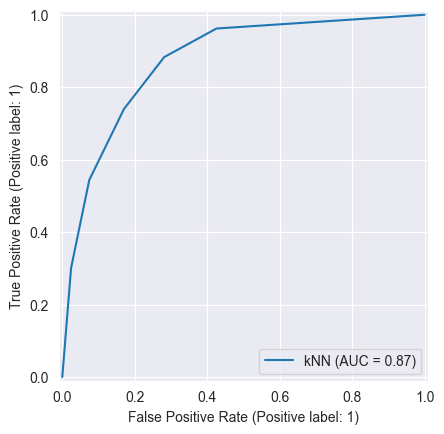



--- SVM ---
SVM Accuracy: 0.756
SVM F1 Score: 0.561
SVM LogLoss: 0.491
SVM ROC AUC: 0.817
SVM Confusion Matrix:
 [[600  58]
 [186 156]]


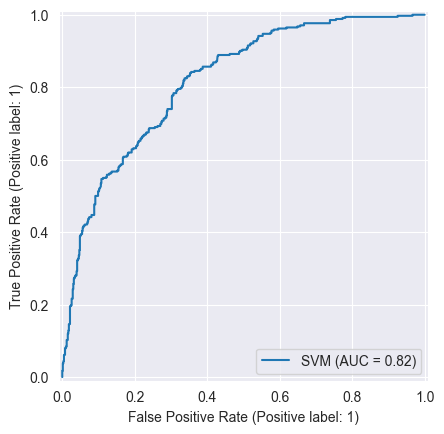

In [11]:
from sklearn.metrics import RocCurveDisplay

# kNN
evaluate(y_test, y_pred_knn, y_prob_knn, model_name="kNN")

# SVM
evaluate(y_test, y_pred_svm, y_prob_svm, model_name="SVM")




In [12]:
class_counts = df['adr_class'].value_counts()
print(class_counts)

class_ratios = df['adr_class'].value_counts(normalize=True)
print(class_ratios)

adr_class
0    3381
1    1619
Name: count, dtype: int64
adr_class
0    0.6762
1    0.3238
Name: proportion, dtype: float64


In [69]:
# Разделяем по классам
class_0 = df[df['adr_class'] == 0]
class_1 = df[df['adr_class'] == 1]

# Берём столько же объектов из класса 0, сколько в классе 1
class_0_downsampled = class_0.sample(len(class_1), random_state=123)

df_balanced = pd.concat([class_0_downsampled, class_1])
print(df_balanced['adr_class'].value_counts())


adr_class
0    1619
1    1619
Name: count, dtype: int64


--- kNN ---
kNN Accuracy: 0.778
kNN F1 Score: 0.791
kNN LogLoss: 1.78
kNN ROC AUC: 0.853
kNN Confusion Matrix:
 [[232  92]
 [ 52 272]]


--- SVM ---
SVM Accuracy: 0.718
SVM F1 Score: 0.715
SVM LogLoss: 0.543
SVM ROC AUC: 0.796
SVM Confusion Matrix:
 [[236  88]
 [ 95 229]]




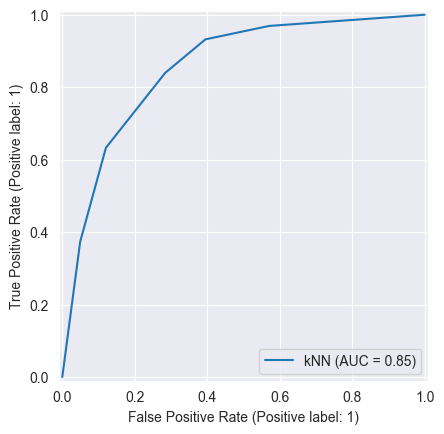

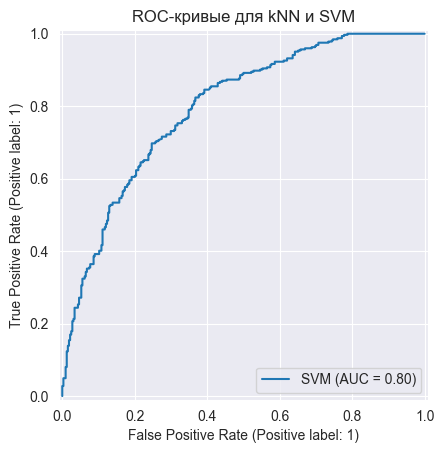

In [70]:
X_bal = df_balanced[features]
y_bal = df_balanced['adr_class']

X_train, X_test, y_train, y_test = train_test_split(
    X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)
y_prob_knn = knn.predict_proba(X_test_scaled)[:,1]

svm_clf = SVC(kernel='rbf', C=1, gamma=0.01, probability=True)
svm_clf.fit(X_train_scaled, y_train)
y_pred_svm = svm_clf.predict(X_test_scaled)
y_prob_svm = svm_clf.predict_proba(X_test_scaled)[:,1]



evaluate(y_test, y_pred_knn, y_prob_knn, "kNN")
evaluate(y_test, y_pred_svm, y_prob_svm, "SVM")

RocCurveDisplay.from_predictions(y_test, y_prob_knn, name='kNN')
RocCurveDisplay.from_predictions(y_test, y_prob_svm, name='SVM')
plt.title("ROC-кривые для kNN и SVM")
plt.show()

1 done
2 done
3 done
4 done
5 done

--- Средние результаты kNN ---
Accuracy: 0.813
F1: 0.716
Logloss: 1.231
Roc_auc: 0.879

--- Средние результаты SVM ---
Accuracy: 0.760
F1: 0.544
Logloss: 0.482
Roc_auc: 0.817


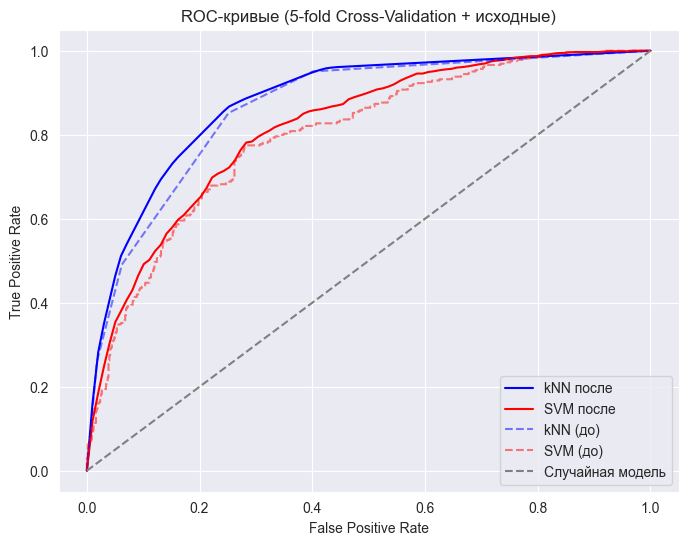

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score, roc_curve

# Для ROC из исходного эксперимента (до балансировки)
base_knn_fpr, base_knn_tpr, _ = roc_curve(y_test, y_prob_knn)
base_svm_fpr, base_svm_tpr, _ = roc_curve(y_test, y_prob_svm)


kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

knn_results = {'accuracy': [], 'f1': [], 'logloss': [], 'roc_auc': []}
svm_results = {'accuracy': [], 'f1': [], 'logloss': [], 'roc_auc': []}

knn_tprs, svm_tprs = [], []
mean_fpr = np.linspace(0, 1, 100)

for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- kNN ---
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)
    y_pred_knn = knn.predict(X_test_scaled)
    y_prob_knn = knn.predict_proba(X_test_scaled)[:, 1]

    knn_results['accuracy'].append(accuracy_score(y_test, y_pred_knn))
    knn_results['f1'].append(f1_score(y_test, y_pred_knn))
    knn_results['logloss'].append(log_loss(y_test, y_prob_knn))
    knn_results['roc_auc'].append(roc_auc_score(y_test, y_prob_knn))

    # ROC для kNN
    fpr, tpr, _ = roc_curve(y_test, y_prob_knn)
    knn_tprs.append(np.interp(mean_fpr, fpr, tpr))
    knn_tprs[-1][0] = 0.0

    # --- SVM ---
    svm_clf = SVC(kernel='rbf', C=1, gamma=0.01, probability=True)
    svm_clf.fit(X_train_scaled, y_train)
    y_pred_svm = svm_clf.predict(X_test_scaled)
    y_prob_svm = svm_clf.predict_proba(X_test_scaled)[:, 1]

    svm_results['accuracy'].append(accuracy_score(y_test, y_pred_svm))
    svm_results['f1'].append(f1_score(y_test, y_pred_svm))
    svm_results['logloss'].append(log_loss(y_test, y_prob_svm))
    svm_results['roc_auc'].append(roc_auc_score(y_test, y_prob_svm))

    # ROC для SVM
    fpr, tpr, _ = roc_curve(y_test, y_prob_svm)
    svm_tprs.append(np.interp(mean_fpr, fpr, tpr))
    svm_tprs[-1][0] = 0.0

    print(f"{fold} done")

print("\n--- Средние результаты kNN ---")
for metric, values in knn_results.items():
    print(f"{metric.capitalize()}: {np.mean(values):.3f}")

print("\n--- Средние результаты SVM ---")
for metric, values in svm_results.items():
    print(f"{metric.capitalize()}: {np.mean(values):.3f}")

mean_knn_tpr = np.mean(knn_tprs, axis=0)
mean_knn_tpr[-1] = 1.0
mean_knn_auc = np.mean(knn_results['roc_auc'])

mean_svm_tpr = np.mean(svm_tprs, axis=0)
mean_svm_tpr[-1] = 1.0
mean_svm_auc = np.mean(svm_results['roc_auc'])

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_knn_tpr, color='blue', label=f'kNN после')
plt.plot(mean_fpr, mean_svm_tpr, color='red', label=f'SVM после')

plt.plot(base_knn_fpr, base_knn_tpr, color='blue', linestyle='--', alpha=0.5, label='kNN (до)')
plt.plot(base_svm_fpr, base_svm_tpr, color='red', linestyle='--', alpha=0.5, label='SVM (до)')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Случайная модель')
plt.title("ROC-кривые (5-fold Cross-Validation + исходные)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, accuracy_score, f1_score, log_loss, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='rbf', probability=True)
log_reg = LogisticRegression(max_iter=1000)

voting_hard = VotingClassifier(estimators=[
    ('knn', knn),
    ('svm', svm),
    ('logreg', log_reg)
], voting='hard')

voting_soft = VotingClassifier(estimators=[
    ('knn', knn),
    ('svm', svm),
    ('logreg', log_reg)
], voting='soft')

for model in [knn, svm, log_reg, voting_hard, voting_soft]:
    model.fit(X_train, y_train)

def evaluate(y_true, y_pred, y_prob, model_name):
    print(f"--- {model_name} ---")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 3))
    print("F1 Score:", round(f1_score(y_true, y_pred), 3))
    print("LogLoss:", round(log_loss(y_true, y_prob), 3))
    print("ROC AUC:", round(roc_auc_score(y_true, y_prob), 3))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print()

models = {
    "kNN": knn,
    "SVM": svm,
    "Logistic Regression": log_reg,
    "Voting (Hard)": voting_hard,
    "Voting (Soft)": voting_soft
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = y_pred 
    evaluate(y_test, y_pred, y_prob, name)




--- kNN ---
Accuracy: 0.801
F1 Score: 0.693
LogLoss: 1.532
ROC AUC: 0.867
Confusion Matrix:
 [[576  82]
 [117 225]]

--- SVM ---
Accuracy: 0.658
F1 Score: 0.0
LogLoss: 0.558
ROC AUC: 0.744
Confusion Matrix:
 [[658   0]
 [342   0]]

--- Logistic Regression ---
Accuracy: 0.747
F1 Score: 0.551
LogLoss: 0.521
ROC AUC: 0.791
Confusion Matrix:
 [[592  66]
 [187 155]]

--- Voting (Hard) ---
Accuracy: 0.751
F1 Score: 0.491
LogLoss: 8.975
ROC AUC: 0.655
Confusion Matrix:
 [[631  27]
 [222 120]]

--- Voting (Soft) ---
Accuracy: 0.774
F1 Score: 0.608
LogLoss: 0.451
ROC AUC: 0.864
Confusion Matrix:
 [[599  59]
 [167 175]]



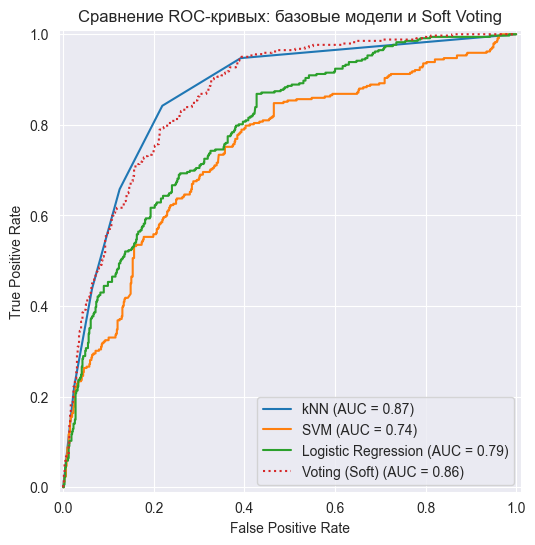

In [26]:
plt.figure(figsize=(8, 6))

RocCurveDisplay.from_estimator(knn, X_test, y_test, name='kNN', ax=plt.gca())
RocCurveDisplay.from_estimator(svm, X_test, y_test, name='SVM', ax=plt.gca())
RocCurveDisplay.from_estimator(log_reg, X_test, y_test, name='Logistic Regression', ax=plt.gca())
RocCurveDisplay.from_estimator(
    voting_soft,
    X_test, y_test,
    name='Voting (Soft)',
    ax=plt.gca(),
    curve_kwargs={'linestyle': ':'}
)

plt.title("Сравнение ROC-кривых: базовые модели и Soft Voting")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

--- AdaBoost ---
Accuracy: 0.882
F1 Score: 0.82
LogLoss: 0.578
ROC AUC: 0.951
Confusion Matrix:
 [[614  44]
 [ 74 268]]



<Figure size 800x600 with 0 Axes>

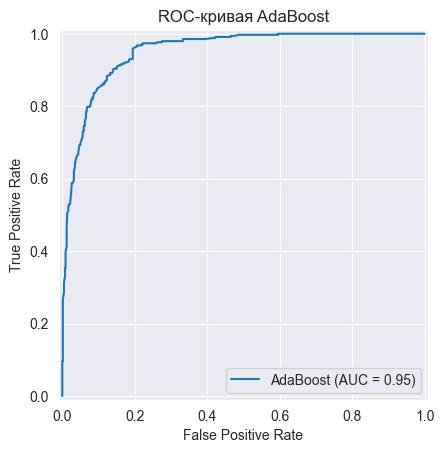

In [29]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt

base_tree = DecisionTreeClassifier(max_depth=1, random_state=42)

adaboost_clf = AdaBoostClassifier(
    estimator=base_tree,
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

adaboost_clf.fit(X_train, y_train)

y_pred_ada = adaboost_clf.predict(X_test)
y_prob_ada = adaboost_clf.predict_proba(X_test)[:,1]

evaluate(y_test, y_pred_ada, y_prob_ada, "AdaBoost")

plt.figure(figsize=(8,6))
RocCurveDisplay.from_estimator(adaboost_clf, X_test, y_test, name='AdaBoost')
plt.title("ROC-кривая AdaBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()


--- kNN ---
Accuracy: 0.801
F1 Score: 0.693
LogLoss: 1.532
ROC AUC: 0.867
Confusion Matrix:
 [[576  82]
 [117 225]]

--- SVM ---
Accuracy: 0.658
F1 Score: 0.0
LogLoss: 0.558
ROC AUC: 0.744
Confusion Matrix:
 [[658   0]
 [342   0]]

--- AdaBoost ---
Accuracy: 0.882
F1 Score: 0.82
LogLoss: 0.578
ROC AUC: 0.951
Confusion Matrix:
 [[614  44]
 [ 74 268]]



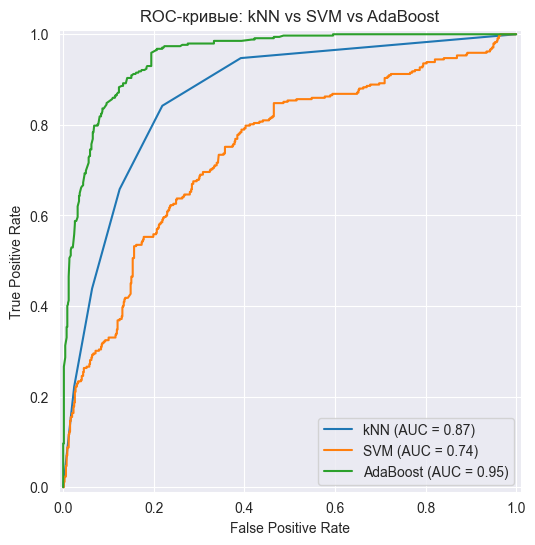

In [30]:
from sklearn.metrics import RocCurveDisplay, accuracy_score, f1_score, log_loss, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
models = {
    "kNN": knn,
    "SVM": svm,
    "AdaBoost": adaboost_clf
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:,1]
    else:
        y_prob = y_pred
    evaluate(y_test, y_pred, y_prob, name)


plt.figure(figsize=(8,6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        RocCurveDisplay.from_estimator(model, X_test, y_test, name=name, ax=plt.gca())
    else:
        RocCurveDisplay.from_predictions(y_test, model.decision_function(X_test), name=name, ax=plt.gca())

plt.title("ROC-кривые: kNN SVM AdaBoost")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()

Метрики до upsampling:
--- kNN (original) ---
Accuracy: 0.796
F1 Score: 0.684
LogLoss: 1.04
ROC AUC: 0.877
Confusion Matrix:
 [[575 101]
 [103 221]]

--- SVM (original) ---
Accuracy: 0.78
F1 Score: 0.567
LogLoss: 0.461
ROC AUC: 0.838
Confusion Matrix:
 [[636  40]
 [180 144]]

Метрики после upsampling:
--- kNN (upsampled) ---
Accuracy: 0.835
F1 Score: 0.846
LogLoss: 1.466
ROC AUC: 0.91
Confusion Matrix:
 [[519 158]
 [ 65 611]]

--- SVM (upsampled) ---
Accuracy: 0.748
F1 Score: 0.746
LogLoss: 0.512
ROC AUC: 0.825
Confusion Matrix:
 [[511 166]
 [175 501]]



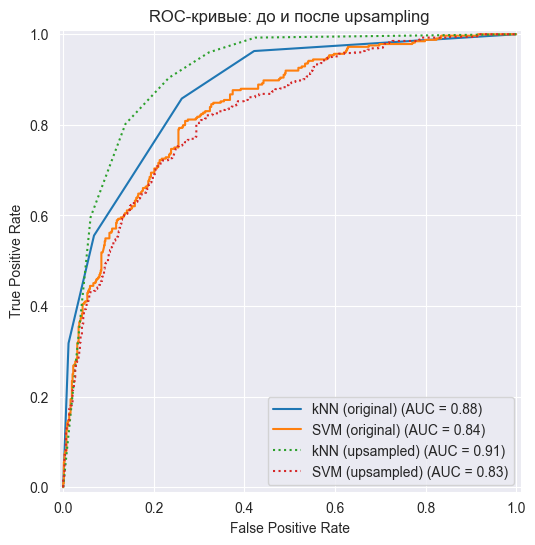

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, accuracy_score, f1_score, log_loss, roc_auc_score, confusion_matrix

X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler_orig = StandardScaler()
X_train_orig_scaled = scaler_orig.fit_transform(X_train_orig)
X_test_orig_scaled = scaler_orig.transform(X_test_orig)

knn_orig = KNeighborsClassifier(n_neighbors=5)
knn_orig.fit(X_train_orig_scaled, y_train_orig)
y_pred_knn_orig = knn_orig.predict(X_test_orig_scaled)
y_prob_knn_orig = knn_orig.predict_proba(X_test_orig_scaled)[:,1]

svm_orig = SVC(kernel='rbf', probability=True, C=1, gamma=0.01)
svm_orig.fit(X_train_orig_scaled, y_train_orig)
y_pred_svm_orig = svm_orig.predict(X_test_orig_scaled)
y_prob_svm_orig = svm_orig.predict_proba(X_test_orig_scaled)[:,1]


print("Метрики до upsampling:")
evaluate(y_test_orig, y_pred_knn_orig, y_prob_knn_orig, "kNN (original)")
evaluate(y_test_orig, y_pred_svm_orig, y_prob_svm_orig, "SVM (original)")

print("Метрики после upsampling:")
evaluate(y_test, y_pred_knn, y_prob_knn, "kNN (upsampled)")
evaluate(y_test, y_pred_svm, y_prob_svm, "SVM (upsampled)")


plt.figure(figsize=(8,6))
RocCurveDisplay.from_predictions(y_test_orig, y_prob_knn_orig, name='kNN (original)', ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_orig, y_prob_svm_orig, name='SVM (original)', ax=plt.gca())
RocCurveDisplay.from_predictions(y_test, y_prob_knn, name='kNN (upsampled)', ax=plt.gca(), curve_kwargs={'linestyle':':'})
RocCurveDisplay.from_predictions(y_test, y_prob_svm, name='SVM (upsampled)', ax=plt.gca(), curve_kwargs={'linestyle':':'})

plt.title("ROC-кривые: до и после upsampling")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()
